# Statistical Learning Final Project: Predicting Supreme Court Outcomes
_by Miranda Seitz-McLeese_

Author's note: I have chosen to do this project in an INotebook. My project makes heavy use of [pandas](http://pandas.pydata.org) and [scikit-learn](http://scikit-learn.org/stable/index.html).

## Customer
For this project I was inspired by my friends who are in law school, who showed me some data sets that were available in that area. Therefore my imagined customer is a law firm, who wants to be able to accurately tell their clients how the argument went, and what the likely outcome was. Additionally, a law firm might want to know what effective advocates might do to increase the likelihood of securing a victory for their clients. Finally a law firm, or any lawyer engaged in legal research might be interested in finding cases that deal with similar facts.


## Objective
I had three objectives for this analysis, which I breifly mentioned above:
1. Cluster cases based on facts to allow legal researchers to find similar cases.
2. Predict the outcome of a case (for this analysis, restricted to Supreme Court cases, because of the data available).
3. Analyze feature importance based on my model for the first objective to see what makes for an effective argument.

## Data
I mined my data from two locations. First I got the transcripts, some justice voting data, and facts, as well as some other data, that I ended up not using for this analysis from [The Oyez Project](https://www.oyez.org). I got some other decision data from [The Supreme Court Database](http://supremecourtdatabase.org/), as well as meta data about proceedural history and parties that I did not end up using for my analysis.

[The Supreme Court Database](http://supremecourtdatabase.org/) provides downloads in comma separated value file formats, and I used [scrapy](http://scrapy.org) to scrape the data from [The Oyez Project](https://www.oyez.org). I combined these sources in an SQL database. 

In order to perform my analysis, I wrote a function that would pull the data from my SQL database into a [pandas](http://pandas.pydata.org) DataFrame and then perform some basic cleaning and transformations to consolodate the data so I have only one row for each case.

Below I use this function to read in the data. The full text for the function can be found in the learn submodule of the scotus module source code. 

In [1]:
% load_ext autoreload
from scotus.learn.data import lines_data
data = lines_data()

I have 254 different features in this dataframe, as well as some columns containing metadata, and my vote and outcome data. For ease of reading throughout the rest of this document I have split them into categories below, so that I may access the features I need for my analysis. In the code below I have comments with a brief description of the feature.

In [3]:
column_names = data.columns.values

facts = ['facts']  # a one to two paragraph summary of the facts of the case.

speaker = ['speaker'] # this is a paragraph that lists the names of the speakers in the order they
                      # spoke during the argument.

turn_text = [x for x in column_names if x.split('_')[0]=='text'] # this is multiple features, one text document
                                                                 # per justice/advocate per party to the case
                                                                 # with all statements from that justice or advocate
                                                                 # during that party's speaking time.

count_features = ['turns', 'question', 'interrupted', 'interruption', 'humor']

count = [x for x in column_names if x.split('_')[0] in count_features] # this is multiple features, one for each
                                                                       # statistic per justice/advocate per party
                                                                       # counting the number of occurances during 
                                                                       # that party's speaking time.

length = [x for x in column_names if x.split('_')[0] == 'length']      # this is multiple features, one for each
                                                                       # one per justice/advocate per party
                                                                       # containing the number of seconds that 
                                                                       # justice/advocate spoke during that party's 
                                                                       # speaking time.


## Clustering
In this section I will discuss the analysis and results for the first goal I had, namely to cluster cases based on facts to allow legal researchers to find similar cases. The analysis in this section only makes use of the data in the 'facts' feature.

### Techniques
This is an unsupervized problem, because I do not have a training set, but rather I am interested in finding patterns and clusters in the data. Therefore I used k-means clustering to find the clusters, and Latant Semantic Analysis for dimensionality reduction. I chose these techniques because they were unsupervized. Additionally, because I am looking for "similar" cases it makes sense to choose features, and a distance metric such that cases that are "similar" are "near" to each other in my feature space. I chose k-means clustering largely for computational reasons and my results were good.

### Considerations 
The first thing I had to condend with in this analysis was the curse of dimensionality. My features here were word counts from the two paragraph description of the facts of the case. This made my feature space sparse and gave it a very high dimensionality. To deal with this I used Latant Semantic Analysis (LSA) to project my feature space down to a smaller feature space of only 100 dimensions. This will also help with overfitting. Additionally to minimize the risks of bias/overfitting, I required words to show up in at least three documents before I included them in my vocabulary and I limited the number of clusters.

### Results
Running LSA on the facts worked increadibly well to pull out topics from the cases. I actually worked with a friend in lawschool who was able to confirm for me that these topics were indeed actual areas of legal interest. Below I have generated a few word clouds to show some of the topics. For example, the second column separates criminal cases from civil cases.

In [28]:
% aimport scotus.learn.clustering
% autoreload 1

lsa = scotus.learn.clustering.lsa_model()
facts_lsa = lsa.fit_transform(data)
scotus.learn.clustering.word_cloud(lsa, 1, n_words=10)

PLUS: trial|sentence|habeas|murder|jury|convicted|death|conviction|sentenced|petition

MINUS: act|suit|plan|sued|employees|company|action|tax|employee|judgment


And this separates *habeus corpus* claims from fourth amendment cases

In [29]:
scotus.learn.clustering.word_cloud(lsa, 2, n_words=10)

PLUS: search|police|officers|officer|fourth amendment|arrested|drug|fourth|amendment|warrant

MINUS: habeas|petition|habeas corpus|corpus|death|murder|relief|federal habeas|state court|counsel


And this separates statute of limitation claims from class action and arbitration claims.

In [30]:
scotus.learn.clustering.word_cloud(lsa, 20, n_words=10)

PLUS: limitations|statute|statute limitations|judge|patent|law|year|claims|government|federal

MINUS: class|arbitration|granted|court granted|title|plaintiffs|circuit affirmed|relief|class action|affirmed


The law is a fractal and hierarchical topic area. So in theory the number of clusters could be quite large. However, in practice I found ten clusters to result in the most sensible results, and the results that correlated best with the topics that my LSA was pulling out, which I had verified as good with my fried who has subject matter expertise. In the plot below you can see the cluster of fourth amendment cases (purple top right) distinguished from the habeus cases (green, bottom right).

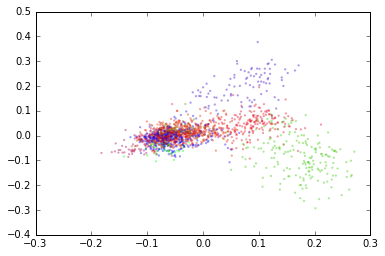

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
clustering = KMeans(n_clusters=10)
predicted_clusters = clustering.fit_predict(facts_lsa)
plt.scatter(facts_lsa[:,1], facts_lsa[:,2], c=predicted_clusters, cmap='brg', s=5, alpha=.4, lw=0)
plt.show()

## Prediction

In this section I discuss my attempts to predict the outcome of Supreme Court Cases. This was signifigantly more difficult than the clustering problem, and I suspect that more data/different data would be needed to make any additional improvements to this algorithm.

### Techniques
I tried practically every classification technique covered in class (with the exeption of neural networks) on this problem. However in the interest of time and space, I will limit myself to the two most promising. Those were Multinomial Naive Bayes, and Logistic Regression. I chose these based on my data, as well as by trial and error. In this case I was using all almost 250 features, several of which were text features that I then vectorized using count data. I was working with extremely large, sparse matricies.  Therefore I needed something that was friendly to sparse data and scaled well to number of features. This ruled out LDA, which doesn't like sparse features. Additionally I was able to rule out Support Vector Machines and Decision Trees, which don't do well with large dimensonal spaces. I did attempt to use LSA as in the clustering example to reduce my dimensionality, however in no case did an algorithm using LSA features outperform an algorithm directly working with the sparse features.

### Considerations
When you have more than 10,000 features, you have to be really careful about overfitting, so I used an agressive bagging and bootstrapping approach to minimize this in my Naive Bayes model. In my Logistic Regression model I used this as well, but I also added a lasso penalty term to enforce sparsity in my feature space. I used cross-validation to set the penalty parameter, as well as my bagging and bootstrapping parameters. Finally I witheld a testing set to ensure that I wasn't overfitting to my training set.

In [ ]:
def prep_justice(name, data):
    vote_col = 'vote_side_'+ name
    X = data[(data[vote_col] == -1)|(data[vote_col]==1)]
    y = data[vote_col]
    return X, y

j_names = ['kennedy', 'thomas', 'ginsburg', 'breyer', 'roberts', 'alito', 'sotomayor', 'kagan']
j_data = {name:prep_justice(name, d) for name in j_names}

roberts_data, roberts_y = prep_justice('roberts', data)
alito_data, alito_y = prep_justice('alito', data)
ginsburg_data, ginsburg_y = prep_justice('ginsburg', data)
kennedy_data, kennedy_y = prep_justice('kennedy', data)
thomas_data, thomas_y = prep_justice('thomas', data) 
breyer_data, breyer_y = prep_justice('breyer', data) 
kagan_data, kagan_y = prep_justice('kagan', data)
sotomayor_data, sotomayor_y = prep_justice('sotomayor', data)